In [32]:
import pydicom as dicom
import matplotlib.pylab as plt
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import cv2
from enum import Enum
from skimage.transform import resize
from skimage.measure import label, regionprops, regionprops_table
import math
import matplotlib.patches as patches
import SimpleITK as sitk
import os
import shutil

base_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/'


"axial slices" - ? 
"axial plane" - ? I assume it means looking as a single image

Need to filter the images in the dataset.

(LEFT OUT FOR NOW - split the volume into slices for the model training (due to variance in the slice thickness?)) 

MR AND CT:

    * discard the axial slices that do not contain foreground -> if the gt of the image is empty w.r.t our classes of interest, then discard it

    * crop out the non-body region -> take the bounding box of the positive pixels, and crop the image to this bounding box
    
    * uniformly resized to 256 x 256 in axial plane

    * min-max norm to normalize to [0,1]

CT:

    * clip the value range to [-125, 275]

In [33]:
# interesting classes : 

# CLASS TO NUMBER
# (1) spleen
# (2) right kidney
# (3) left kidney
# (6) liver

class TAGS(Enum): 
    SPLEEN = 1
    RIGHT_KIDNEY = 2
    LEFT_KIDNEY = 3
    LIVER = 4


# MRI (CHAOS)
# Liver: 63 (55<<<70)
# Right kidney: 126 (110<<<135)
# Left kidney: 189 (175<<<200)
# Spleen: 252 (240<<<255) 

MRI_NUM_TO_TAG: dict = {
    252 : TAGS.SPLEEN.value,
    189: TAGS.LEFT_KIDNEY.value,
    126 : TAGS.RIGHT_KIDNEY.value,
    63: TAGS.LIVER.value
}



# CT - SYNAPSE (2015)
# (1) spleen
# (2) right kidney
# (3) left kidney
# (6) liver

CT_NUM_TO_TAG: dict = {
    1 : TAGS.SPLEEN.value,
    2 : TAGS.RIGHT_KIDNEY.value,
    3 : TAGS.LEFT_KIDNEY.value,
    6 : TAGS.LIVER.value
}


In [34]:

def setup_img_fig(img1 : np.ndarray, img2: np.ndarray):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))  # Adjust figsize for image sizes

    axes[0].imshow(img1)
    axes[0].set_title("Image 1")
    axes[0].axis('off')  # Hide axes for cleaner presentation

    axes[1].imshow(img2)
    axes[1].set_title("Image 2")
    axes[1].axis('off')
    
    return fig,axes

def get_bbox(array: np.ndarray):
    array_for_bbox =  (array > 0).astype(np.uint8)
    
    bbox = regionprops(array_for_bbox)[0].bbox
    
    return bbox

def get_bbox_fixed(array: np.ndarray, outside_val):
    array_for_bbox =  (array > outside_val).astype(np.uint8)
    
    bbox = regionprops(array_for_bbox)[0].bbox
    
    return bbox


def get_bbox_for_batch(array: np.ndarray):
    bbox_list = []
    num_in_batch = array.shape[2]
    for i in range(num_in_batch):
        sub_array = array[:,:,i]
        bbox = get_bbox(sub_array)
        bbox_list.append(bbox)
    return np.stack(bbox_list)

def get_bbox_fixed_for_batch(array: np.ndarray, outside_val):
    bbox_list = []
    num_in_batch = array.shape[2]
    for i in range(num_in_batch):
        sub_array = array[:,:,i]
        # bbox = get_bbox_fixed(sub_array, outside_val)
        bbox = get_china_bbox(sub_array)
        bbox_list.append(bbox)
    return np.stack(bbox_list)

def show_bbox_on_image(ax, bbox):
    y_size = bbox[2] - bbox[0]
    x_size = bbox[3] - bbox[1]
    rect = patches.Rectangle((bbox[1], bbox[0]), x_size, y_size, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
def create_nonzero_mask(data):
    from scipy.ndimage import binary_fill_holes
    assert len(data.shape) == 3 or len(data.shape) == 2, "data must have shape (X, Y, Z) or shape (X, Y)"
    nonzero_mask = (data > -100)
    nonzero_mask = binary_fill_holes(nonzero_mask)
    return nonzero_mask


def get_china_bbox(array: np.ndarray):
    nonzero_mask = create_nonzero_mask(array)
    bbox = get_bbox_from_mask(nonzero_mask, 0)
    return bbox

def get_bbox_from_mask(mask, outside_value=0):
    mask_voxel_coords = np.where(mask != outside_value)
    minzidx = int(np.min(mask_voxel_coords[0]))
    maxzidx = int(np.max(mask_voxel_coords[0])) + 1
    minxidx = int(np.min(mask_voxel_coords[1]))
    maxxidx = int(np.max(mask_voxel_coords[1])) + 1
    return [minzidx, minxidx, maxzidx, maxxidx]

def norm_to_zero_mean_unit_var(arr, mean, std):
    return (arr - mean) / std
    

Start with MRI


constants

In [35]:
training_size : tuple = (256,256)

In [36]:
prod_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT'

mr_path_train = prod_path +  '/train'
mr_path_test = prod_path +  '/test'
if os.path.exists(mr_path_train):
    shutil.rmtree(mr_path_train, ignore_errors=True)
if os.path.exists(mr_path_test):
    shutil.rmtree(mr_path_test, ignore_errors=True)

os.makedirs(mr_path_train,exist_ok=True)
os.makedirs(mr_path_test,exist_ok=True)

In [37]:
import random 
import os 
import re

files = [ f.path.split('/')[-1] for f in os.scandir(base_path) ]
files = [int(f.split('.')[0].split('mg')[1]) for f in files]
random.shuffle(files)
train_size = int(len(files) * 0.8)

# train_vols = set(files[:train_size])
# test_vols = set(files[train_size:])

train_vols = set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38])
test_vols = set([34, 39, 40, 22, 24, 31])


print(f"train vols: {train_vols}")
print(f"test vols: {test_vols}")

def is_train_vol(vol: str):
    return vol in train_vols

def get_data_save_path_ct(im_path: str, slice_idx:int):
    im_name = im_path.split('/')[-1].split('.')[0]
    vol = int(im_name.split('mg')[1])
    print(im_name)
    
    im_name_new = f'{im_name}_{slice_idx}'
    im_name = f'/{im_name_new}'
        
    if is_train_vol(vol):
        return mr_path_train + im_name, vol
    else:
        return mr_path_test + im_name, vol

train vols: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38}
test vols: {34, 39, 40, 22, 24, 31}


In [38]:
import os
import re
import random 
# /users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/chaos/train/Train_Sets/MR/8/T2SPIR/DICOM_anon/

base_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img'

im_path_list = []
gt_path_list = []

root_dirs = set()

for root,a,files in os.walk(base_path):
    for file in files:
        full_path = os.path.join(root, file)
        full_path_gt = os.path.join(root.replace('/img', '/label'), file.replace('img','label'))
        im_path_list.append(full_path)
        gt_path_list.append(full_path_gt)
        root_dirs.add(root)
        
        assert(full_path.split('/')[-1].split('.')[0][-4:] == full_path_gt.split('/')[-1].split('.')[0][-4:])


print(im_path_list)
print(gt_path_list)
print(root_dirs)

['/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0001.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0031.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0026.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0005.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0023.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0022.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0004.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0028.nii.gz', '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/A

In [40]:
# im_path_list = [mr_path]
# gt_path_list = [gt_mr_path]
from dataclasses import dataclass

@dataclass
class VolData:
    data_path: str
    image:  np.ndarray
    label: np.ndarray
    

vol_to_arr : dict[str,list[VolData]] = {}

for im_path,gt_path in zip(im_path_list,gt_path_list):
    
    mr_im = nib.load(im_path)
        
    gt_mr = nib.load(gt_path).get_fdata()

    # 0 to 1552
    mr_im_data = mr_im.get_fdata()
    
    filtered_gt = np.zeros_like(gt_mr)
    # swap to our tags
    for item in CT_NUM_TO_TAG.items():
        filtered_gt = np.where(gt_mr == item[0], item[1], filtered_gt) 
    
    gt_mr = filtered_gt[:,:,~np.all(filtered_gt==0, axis=(0,1))]
    mr_im_data = mr_im_data[:,:,~np.all(filtered_gt==0, axis=(0,1))]
    
    # filter out empty images, "no foreground"
    if gt_mr.shape[2] == 0:
        continue
    
    # crop out the body region with this bbox
    # **bbox** : tuple
    # Bounding box ``(min_row, min_col, max_row, max_col)``.
    # Pixels belonging to the bounding box are in the half-open interval
    # ``[min_row; max_row)`` and ``[min_col; max_col)``.
    
    
    # bbox_np = get_bbox_for_batch(mr_im_data > 0)
    bbox_fixed_np = get_bbox_fixed_for_batch(mr_im_data, -100)
    
    
    im_list = []
    gt_list = []
    for slc in range(bbox_fixed_np.shape[0]):
        bbox = bbox_fixed_np[slc]
        bbox_fixed = bbox_fixed_np[slc]
        im_cropped = mr_im_data[bbox[0]:bbox[2], bbox[1]:bbox[3], slc]
        gt_cropped = gt_mr[bbox[0]:bbox[2], bbox[1]:bbox[3], slc]
        
        # NOTE - order 0 is `nearest neighbor` interpolation. We need it for the segmentation mask
        # NOTE - The image should be resized with some sort of interpolation,
        resized_gt = resize(gt_cropped, training_size, order=0, mode="edge", clip=True, anti_aliasing=False).astype(np.uint8)
        resized_im = resize(im_cropped.astype(float), training_size, order=3, mode="edge", clip=True, anti_aliasing=False).astype(np.int16)
        
        # minmax norm + clip
        # clipped_im = np.clip(resized_im, -125, 275)
        clipped_im = np.clip(resized_im, -100, 275)
        # normed_im = (clipped_im - clipped_im.min()) / (clipped_im.max() - clipped_im.min())        
        # assert(normed_im.max() == 1)
        # assert(normed_im.min() == 0)
        
        im_list.append(clipped_im)
        gt_list.append(resized_gt)
    stacked_ims = np.stack(im_list)
    stacked_gts = np.stack(gt_list)
    # im_cropped  = mr_im_data[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    # gt_cropped =  gt_mr[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    # print(im_cropped.shape)
    # print(im_cropped.dtype)
    # print(gt_cropped.dtype)
    # print(resized_im.max())
    
    for idx in range(stacked_ims.shape[0]):
        data_path, vol = get_data_save_path_ct(im_path, idx)
        if vol not in vol_to_arr:
            vol_to_arr[vol] = []
        im = stacked_ims[idx]
        gt = stacked_gts[idx]
        gt_newdim = gt[np.newaxis, ...]
        vol_to_arr[vol].append(VolData(data_path, im, gt_newdim))
        
# derive dataset mean, std
all_im_list : list = []
for _,vol_data_list in vol_to_arr.items():
    all_im_list.extend([vol_data.image for vol_data in vol_data_list])
stacked_ims = np.stack(all_im_list)
print("DS STATS")
print(stacked_ims.mean())
print(stacked_ims.std())

derived_mean = stacked_ims.mean()
derived_std = stacked_ims.std()

# normalize
test_norm_list = []
for vol,vol_data_list in vol_to_arr.items():
    for item in vol_data_list:
        item.image =  norm_to_zero_mean_unit_var(item.image, derived_mean, derived_std)
        test_norm_list.append(item.image)
        
#test
stacked_test_norm = np.stack(test_norm_list)
print("Testing normalized values!!! Mean then STD:")
print(stacked_test_norm.mean())
print(stacked_test_norm.std())
print("Min and max values:")
print(f"MAX; {stacked_test_norm.max()}")
print(f"MIN; {stacked_test_norm.min()}")
    
    
for vol, vol_data_list in vol_to_arr.items():
    for idx,vol_data in enumerate(vol_data_list):
        mixed_image = None
        if idx == 0:
            next_slice = vol_data_list[idx+1]
            mixed_image = np.stack([vol_data.image,vol_data.image, next_slice.image])
        elif idx == len(vol_data_list) - 1:
            prev_slice = vol_data_list[idx - 1]
            mixed_image = np.stack([prev_slice.image, vol_data.image,vol_data.image])
        else:
            prev_slice = vol_data_list[idx - 1]
            next_slice = vol_data_list[idx+1]
            # print(f"getting slices {prev_slice}, {idx}, {next_slice}")
            mixed_image = np.stack([prev_slice.image, vol_data.image,next_slice.image])
                    
        img = mixed_image.transpose(1,2,0)
        label = vol_data.label.transpose((1,2,0))[:,:,0]
        
        #flip to match mri orientation
        img = np.flip(img, axis=1)
        img = img.transpose(1,0,2)
        
        label = np.flip(label, axis=1)
        label = label.transpose(1,0)
        
        print(f"saving data to {vol_data.data_path}")
        np.savez(vol_data.data_path, image = img, label = label)
    

img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0001
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031
img0031


Normalize the image according to the MRI avg , std 

In [70]:

dir_path_train = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT/train'
im_list = []
for somep in os.listdir(dir_path_train):
    if 'nfs' in somep:
        continue
    full_p = os.path.join(dir_path_train, somep)
    test_im, test_gt = get_image_labels_from_npz(full_p)
    im_list.append(test_im)

stacked = np.stack(im_list)
print(stacked.mean())
print(stacked.std())
print(stacked.max())
print(stacked.min())

train_mean = stacked.mean()
train_std = stacked.std()

agg = (stacked - train_mean) / train_std

print(agg.mean())

print(np.isnan(stacked).sum())



0.13891707182062546
0.19985338694797303
1.0
0.0
4.206164630710605e-15
0


In [73]:

dir_path_test = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT/test'
im_list = []
for somep in os.listdir(dir_path_test):
    if 'nfs' in somep:
        continue
    full_p = os.path.join(dir_path_test, somep)
    test_im, test_gt = get_image_labels_from_npz(full_p)
    # print(test_im.shape)
    im_list.append(test_im)
    # print(len(test_im))

stacked = np.stack(im_list)

print(stacked.mean())
print(stacked.std())
print('\n')


stacked = (stacked - train_mean) / train_std

print(stacked.mean())
print(stacked.std())
print(np.isnan(stacked).sum())
print('\n')

print(stacked.min())
print(stacked.max())



0.12601800203476682
0.18954576552421812


-0.06454266291327143
0.9484240843692184
0


-0.6950949090334363
4.308573106161751


In [74]:

print(stacked.shape)

num = 0
for somep in os.listdir(dir_path_test):
    if 'nfs' in somep:
        continue
    full_p = os.path.join(dir_path_test, somep)
    updated_im = stacked[num]    
    test_im_npz = np.load(full_p) 
    im, la = test_im_npz['image'], test_im_npz['label']
    
    if(np.isnan(updated_im).sum() > 0):
        print("trouble")
    if(np.isnan(la).sum() > 0):
        print("trouble")    
    np.savez(full_p, image = updated_im, label = la)
    num += 1
    # print(len(test_im))


(311, 256, 256, 3)


In [1]:
# test that the data was created successfully
import numpy as np 

def get_image_labels_from_npz(npz_path: str):
    test_im_npz = np.load(npz_path)    
    return test_im_npz["image"], test_im_npz["label"]

test_im_gt_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT/train/img0001_0.npz'
test_im_same_vol_gt_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT/train/img0001_1.npz'
test_im_diff_vol_gt_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/prod/CT/train/img0006_55.npz'

test_im, test_gt = get_image_labels_from_npz(test_im_gt_path)
test_im_same_vol, test_gt_same_vol = get_image_labels_from_npz(test_im_same_vol_gt_path)
test_im_diff_vol, test_gt_diff_vol = get_image_labels_from_npz(test_im_diff_vol_gt_path)

assert test_gt.max() > 0
assert test_gt_same_vol.max() > 0
assert test_gt_diff_vol.max() > 0

assert np.all(test_im[:,:,2] == test_im_same_vol[:,:,1])
assert np.all(test_im[:,:,0] == test_im[:,:,1])
assert np.any(test_im[:,:,0] != test_im[:,:,2])

assert np.any(test_im_same_vol[:,:,2] != test_im_same_vol[:,:,1])
assert np.any(test_im_same_vol[:,:,0] != test_im_same_vol[:,:,2])
assert np.any(test_im_same_vol[:,:,0] != test_im_same_vol[:,:,1])

assert np.any(test_im[:,:,2] != test_im_diff_vol[:,:,1])
assert np.any(test_im[:,:,2] != test_im_diff_vol[:,:,2])
assert np.any(test_im[:,:,2] != test_im_diff_vol[:,:,0])

assert np.any(test_gt[:,:] != test_gt_diff_vol[:,:])
assert np.any(test_gt[:,:] != test_gt_diff_vol[:,:])
assert np.any(test_gt[:,:] != test_gt_diff_vol[:,:])

assert np.any(test_gt[:,:] != test_gt_same_vol[:,:])


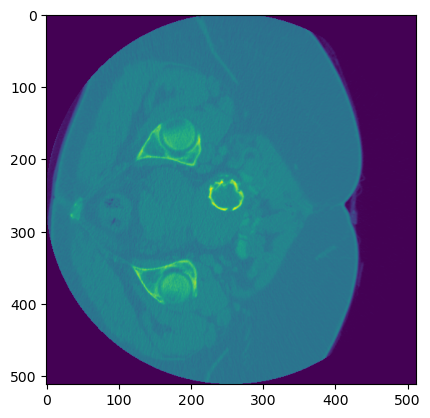

In [8]:
im_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/abdomen/Abdomen/RawData/Training/img/img0010.nii.gz'

mr_im = nib.load(im_path)

mr_im_data = mr_im.get_fdata()

plt.imshow((mr_im_data[:,:,30]).astype(np.int64))